In [1]:
import pandas as pd
import os
import skbio
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
#stats only:
from pingouin import kruskal
import scikit_posthocs as sp
from scipy import stats
from statannot import add_stat_annotation

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# parser = argparse.ArgumentParser(description='TF_diversity_plots')
# parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
# parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
# parser.add_argument('mapped_motif_bed', type=str, help='Input location of promoters mapped motif bed')
# parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '')
# args = parser.parse_args()

In [3]:
dependent_variable = 'TF_diversity'

file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
#Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_schmid_constitutive_tissuespecific_random.txt'
mapped_motif_bed = f'../../data/output/{file_names}/FIMO/promoters_5UTR_motifs_mapped.bed'
output_folder_name ='tau/'
variable2_name = 'tissue_specific'
author_name = 'Schmid'


In [4]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TF_diversity  already exists


In [5]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TF_diversity/tau/  already exists


In [6]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TF_diversity/plots  already exists


In [7]:
def calculate_shannon_diversity(mapped_motif_bed):
    """read in mapped motifs_bed, calculate Shannon diversity"""
    df = pd.read_table(mapped_motif_bed, sep='\t', header=None)
    cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
    df.columns = cols
       
    #count no. of each TF binding in each promoter
    groupby_promoter_counts = df.groupby('promoter_AGI')['TF_AGI'].value_counts().unstack(fill_value=0)    
    #count no. of TF families binding in each promoter
    groupby_promoter_counts_family = df.groupby('promoter_AGI')['TF_family'].value_counts().unstack(fill_value=0)
    #Individual TF shannon diversity using arbitrary log2 base
    shannon_div_df = groupby_promoter_counts.apply(pd.Series(lambda x: skbio.diversity.alpha.shannon(x, base=2)),axis=1)
    #shannon diversity for TF family
    shannon_div_TF_family_df = groupby_promoter_counts_family.apply(pd.Series(lambda x: skbio.diversity.alpha.shannon(x, base=2)),axis=1)
    #convert rownames into column
    cols = ['promoter_AGI', 'shannon']
    shannon_div_df.index.name ='promoter_AGI'
    shannon_div_df.reset_index(inplace=True)
    shannon_div_TF_family_df.index.name ='promoter_AGI'
    shannon_div_TF_family_df.reset_index(inplace=True)
    #rename column
    shannon_div_df.rename(columns = {'<lambda>':'Shannon_diversity_TF'}, inplace = True)
    shannon_div_TF_family_df.rename(columns = {'<lambda>':'Shannon_diversity_TF_family'}, inplace = True)
    #merge individual TF and TF family diversity dfs
    diversity_df = pd.merge(shannon_div_df, shannon_div_TF_family_df, on='promoter_AGI')
    
    ##calculate unique TF counts
    #groupby promoter, and include only unique TFs within each promoter group. Preserve column names.
    unique_TF_count = df.groupby(by='promoter_AGI', as_index=False).agg({'TF_AGI': pd.Series.nunique})
    #rename column
    unique_TF_count.rename(columns = {'TF_AGI':'unique_TF_count'}, inplace = True)
    
    ##calculate total TF counts
    total_TF_count = df.groupby(by='promoter_AGI', as_index=False).agg({'TF_AGI': pd.Series.count})
    #rename column
    total_TF_count.rename(columns = {'TF_AGI':'total_TF_count'}, inplace = True)
    
    ##calculate total TF family counts
    total_TF_family_count = df.groupby(by='promoter_AGI', as_index=False).agg({'TF_family': pd.Series.nunique})
    #rename column
    total_TF_family_count.rename(columns = {'TF_family':'TF_family_count'}, inplace = True)
    
    #merge diversity df with unique_TF_count
    diversity_df = pd.merge(diversity_df,unique_TF_count, on='promoter_AGI' )
    #then merge with total_TF_count
    diversity_df = pd.merge(diversity_df,total_TF_count, on='promoter_AGI' )
    #then merge with TF_family_count
    diversity_df = pd.merge(diversity_df,total_TF_family_count, on='promoter_AGI' )
    return diversity_df 

In [8]:
def merge_shannon_genetype(shannon_df, gene_categories):
    """merge shannon diversity df with gene_categories file"""

    gene_cats = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['gene','gene_type']
    gene_cats.columns = cols
    merged = pd.merge(shannon_df, gene_cats, left_on='promoter_AGI', right_on='gene')
    return merged
    

In [9]:
def all_prom_distribution(df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters GC content"""    
    
    dist_plot = df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_distribution.pdf', format='pdf')    

In [10]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    x=x_variable
    y=y_variable
    order=["constitutive", variable2_name, "control"]
    plot = sns.catplot(x=x, y=y, data=df, kind=plot_kind,order=order)
    #plot points
    ax = sns.swarmplot(x=x, y=y, data=df, color=".25",order=order)
    #add significance if necessary - dunn's posthocs with multiple Bonferroni correction
    stat = dunn_posthoc_test(df,y_variable,x_variable)
    #label box pairs
    box_pairs=[("constitutive", variable2_name),("constitutive", "control"),(variable2_name, "control")]
    #make empty list of p_values
    p_values = []
    #populate the list of p_values accoridng to the box_pairs
    for pair in box_pairs:
        print(pair)
        #select p value for each pair
        p = stat.loc[pair[0],pair[1]]
        p_values.append(p)


    
    #add stats annotation to the plot
#     test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
#                                       box_pairs=box_pairs,
#                                       text_format='star',
#                                       loc='outside',verbose=2,
#                                       perform_stat_test=False,
#                                        pvalues=p_values, test_short_name='Dunn')
    
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #tight layout
    plt.tight_layout()
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [11]:
def make_sub_plot(df,x_variable, y_variable,y_variable2,x_label, y_label,y_label2, output_prefix):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    x=x_variable
    y=y_variable
    order=["constitutive", variable2_name, "control"]
    fig,axs = plt.subplots(ncols = 1,nrows=2,figsize = (8,12))
    plt.subplots_adjust(wspace=0, hspace=0.01)
    
    sns.boxplot(x=x, y=y, data=df,order=order,ax=axs[0])
    #plot points
    sns.swarmplot(x=x, y=y, data=df, color=".25",order=order,ax=axs[0])
    sns.boxplot(x=x, y=y_variable2, data=df,order=order,ax=axs[1])
    
    ax = sns.swarmplot(x=x, y=y_variable2, data=df, color=".25",order=order,ax=axs[1])
    #add significance if necessary - dunn's posthocs with multiple Bonferroni correction
    #stat = dunn_posthoc_test(df,y_variable,x_variable)
    #label box pairs
    #    box_pairs=[("constitutive", "variable"),("constitutive", "control"),("variable", "control")]
    #make empty list of p_values
    #p_values = []
    #populate the list of p_values accoridng to the box_pairs
#     for pair in box_pairs:
#         print(pair)
#         #select p value for each pair
#         p = stat.loc[pair[0],pair[1]]
#         p_values.append(p)


    
    #add stats annotation to the plot
#     test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
#                                       box_pairs=box_pairs,
#                                       text_format='star',
#                                       loc='outside',verbose=2,
#                                       perform_stat_test=False,
#                                        pvalues=p_values, test_short_name='Dunn')
    
    #change axes labels
    axs[0].set_xlabel('')
    axs[0].set(xticks=[])
    axs[0].set_ylabel(y_label)
    axs[1].set_ylabel(y_label2)  
    axs[1].set_xlabel(x_label)
    axs[0].set(title='A')
    axs[1].set(title='B')
    #tight layout
    plt.tight_layout()
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_box_subplots.pdf', format='pdf')   

In [12]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [13]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [14]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [15]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)
    

In [16]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [17]:
#make shannon df
shannon_df = calculate_shannon_diversity(mapped_motif_bed)

In [18]:
#merge shannon diversity df with Czechowski gene_categories file
shannon_Czechowski_gene_categories = merge_shannon_genetype(shannon_df,Czechowski_gene_categories)

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


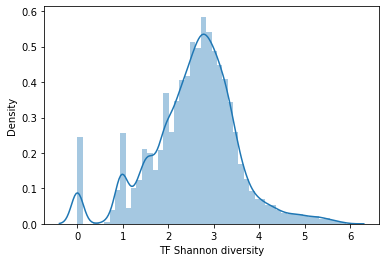

In [19]:
#all promoter distribution plot - Shannon_diversity_TF
all_prom_distribution(shannon_df,'Shannon_diversity_TF', 'TF Shannon diversity', 'TF_diversity_shannon_allproms')

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


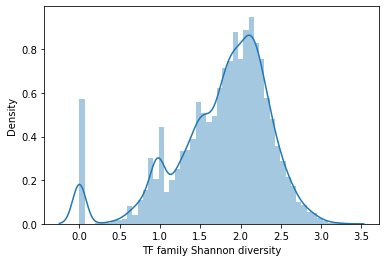

In [20]:
#all promoter distribution plot - Shannon_diversity_TF_family
all_prom_distribution(shannon_df,'Shannon_diversity_TF_family', 'TF family Shannon diversity', 'TFfamily_diversity_shannon_allproms')

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


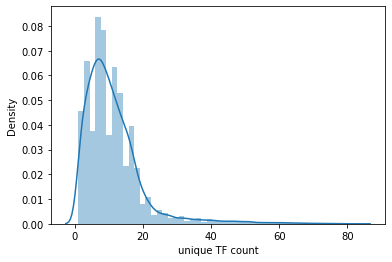

In [21]:
#all promoter distribution plot - unique_TF_count
all_prom_distribution(shannon_df,'unique_TF_count', 'unique TF count', 'unique_TF_count_allproms')

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


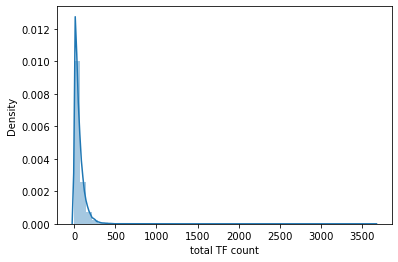

In [22]:
#all promoter distribution plot - total_TF_count
all_prom_distribution(shannon_df,'total_TF_count', 'total TF count', 'total_TF_count_allproms')

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


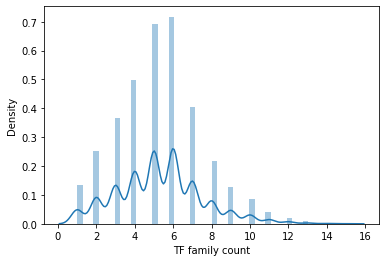

In [23]:
#all promoter distribution plot - TF_family_count
all_prom_distribution(shannon_df,'TF_family_count', 'TF family count', 'TF_family_count_allproms')

In [24]:
shannon_Czechowski_gene_categories

,promoter_AGI,Shannon_diversity_TF,Shannon_diversity_TF_family,unique_TF_count,total_TF_count,TF_family_count,gene,gene_type
0,AT1G01280,2.483127,1.971594,7,29,5,AT1G01280,tissue_specific
1,AT1G01560,2.950212,2.067031,9,14,5,AT1G01560,control
2,AT1G02813,2.251629,1.459148,5,6,3,AT1G02813,tissue_specific
3,AT1G03790,3.001719,2.037210,13,87,7,AT1G03790,tissue_specific
4,AT1G03890,1.219241,1.219241,3,40,3,AT1G03890,tissue_specific
...,...,...,...,...,...,...,...,...
295,AT5G60070,2.447753,1.581754,6,44,4,AT5G60070,tissue_specific
296,AT5G62490,3.438624,2.594801,16,42,8,AT5G62490,tissue_specific
297,AT5G63560,2.730214,2.329882,11,29,7,AT5G63560,tissue_specific
298,AT5G65000,1.737277,1.656251,6,34,5,AT5G65000,control


('constitutive', 'tissue_specific')
('constitutive', 'control')
('tissue_specific', 'control')


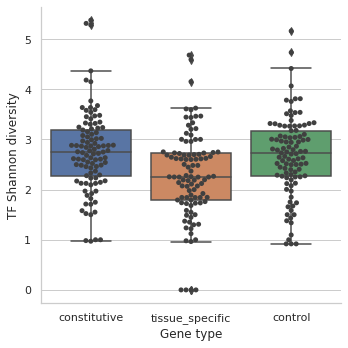

In [25]:
#Czechowski_gene_categories violin and boxplot
#make_plot(shannon_Czechowski_gene_categories,'gene_type','Shannon_diversity_TF','Gene type','TF Shannon diversity', f'Czechowski_TF_diversity', 'violin')
make_plot(shannon_Czechowski_gene_categories,'gene_type','Shannon_diversity_TF','Gene type','TF Shannon diversity', f'{author_name}_TF_diversity', 'box')

('constitutive', 'tissue_specific')
('constitutive', 'control')
('tissue_specific', 'control')


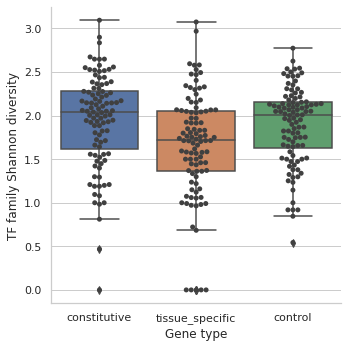

In [26]:
## Czechowski_gene_categories violin and boxplot
#make_plot(shannon_Czechowski_gene_categories,'gene_type','Shannon_diversity_TF_family','Gene type','TF family Shannon diversity', f'Czechowski_TF_family_diversity', 'violin')
make_plot(shannon_Czechowski_gene_categories,'gene_type','Shannon_diversity_TF_family','Gene type','TF family Shannon diversity', f'{author_name}_TF_family_diversity', 'box')

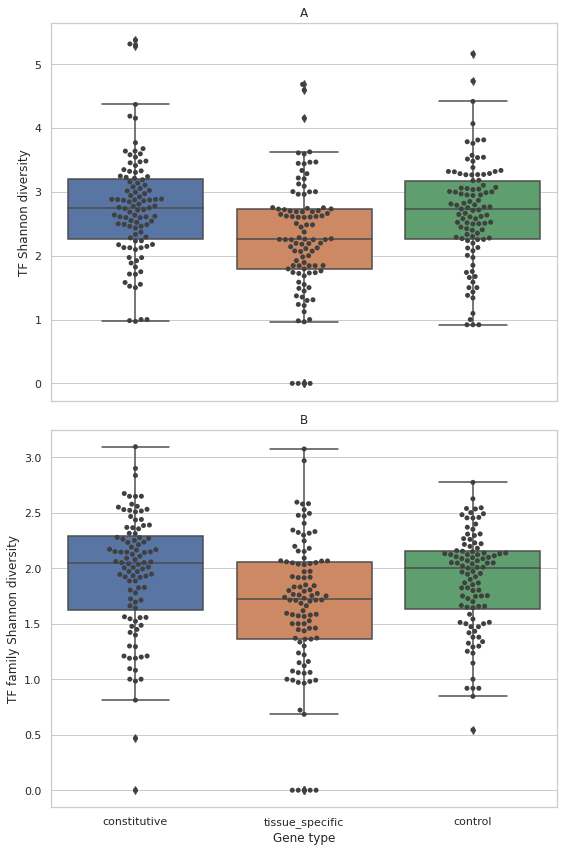

In [27]:
make_sub_plot(shannon_Czechowski_gene_categories,'gene_type', 'Shannon_diversity_TF',
              'Shannon_diversity_TF_family','Gene type','TF Shannon diversity','TF family Shannon diversity',
              f'{author_name}_TF_diversity')

('constitutive', 'tissue_specific')
('constitutive', 'control')
('tissue_specific', 'control')


/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


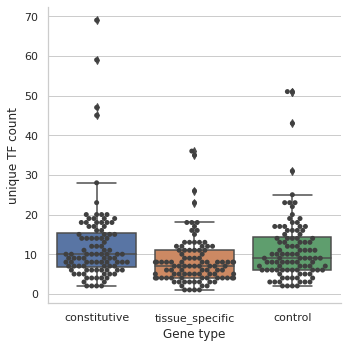

In [28]:
#Czechowski_gene_categories violin and boxplot
#make_plot(shannon_Czechowski_gene_categories,'gene_type','unique_TF_count','Gene type','unique TF count', f'Czechowski_unique_TF_count', 'violin')
make_plot(shannon_Czechowski_gene_categories,'gene_type','unique_TF_count','Gene type','unique TF count', f'{author_name}_unique_TF_count', 'box')

('constitutive', 'tissue_specific')
('constitutive', 'control')
('tissue_specific', 'control')


/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


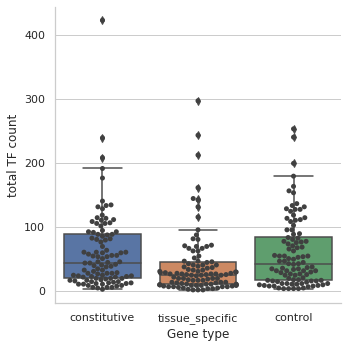

In [29]:
#Czechowski_gene_categories violin and boxplot
#make_plot(shannon_Czechowski_gene_categories,'gene_type','total_TF_count','Gene type','unique TF count', f'Czechowski_unique_TF_count', 'violin')
make_plot(shannon_Czechowski_gene_categories,'gene_type','total_TF_count','Gene type','total TF count', f'{author_name}_unique_TF_count', 'box')

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


('constitutive', 'tissue_specific')
('constitutive', 'control')
('tissue_specific', 'control')


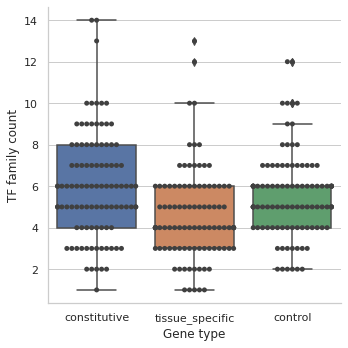

In [30]:
#Czechowski_gene_categories violin and boxplot
#make_plot(shannon_Czechowski_gene_categories,'gene_type','TF_family_count','Gene type','TF family count', f'Czechowski_TF_family_count', 'violin')
make_plot(shannon_Czechowski_gene_categories,'gene_type','TF_family_count','Gene type','TF family count', f'{author_name}_TF_family_count', 'box')

# analyse

In [31]:
#rename df for easier analysis
df = shannon_Czechowski_gene_categories
between_variable = 'gene_type'
dependent_variables = ['Shannon_diversity_TF','Shannon_diversity_TF_family','unique_TF_count','total_TF_count','TF_family_count']

In [32]:
#test normality
for dependent_variable in dependent_variables:
    print(dependent_variable)
    print(test_normality(df,dependent_variable,between_variable))
    print('\n')

Shannon_diversity_TF
tissue_specific: ShapiroResult(statistic=0.975437581539154, pvalue=0.05838564410805702)
control: ShapiroResult(statistic=0.9792908430099487, pvalue=0.1170378029346466)
constitutive: ShapiroResult(statistic=0.9566642045974731, pvalue=0.0023421503137797117)
None


Shannon_diversity_TF_family
tissue_specific: ShapiroResult(statistic=0.9557511210441589, pvalue=0.002025048714131117)
control: ShapiroResult(statistic=0.9660671949386597, pvalue=0.011145601980388165)
constitutive: ShapiroResult(statistic=0.9599267840385437, pvalue=0.003973143175244331)
None


unique_TF_count
tissue_specific: ShapiroResult(statistic=0.8045855760574341, pvalue=3.4325958742087437e-10)
control: ShapiroResult(statistic=0.7747675776481628, pvalue=4.460318225874005e-11)
constitutive: ShapiroResult(statistic=0.6828026175498962, pvalue=2.1822725104845425e-13)
None


total_TF_count
tissue_specific: ShapiroResult(statistic=0.6658732891082764, pvalue=9.258087731774806e-14)
control: ShapiroResult(statis

### not normal

In [33]:
#test normality
for dependent_variable in dependent_variables:
    print(dependent_variable)
    print(variance(df,dependent_variable,between_variable))
    print('\n')

Shannon_diversity_TF
LeveneResult(statistic=0.44302282202169796, pvalue=0.642516170594083)


Shannon_diversity_TF_family
LeveneResult(statistic=2.1775793821889624, pvalue=0.11512141393562811)


unique_TF_count
LeveneResult(statistic=2.3476391872239923, pvalue=0.0973662595048905)


total_TF_count
LeveneResult(statistic=2.641660616790883, pvalue=0.07291656753971039)


TF_family_count
LeveneResult(statistic=2.239843441024451, pvalue=0.10827083244990157)




### fail to reject null hypothesis that variances are equal

In [34]:
#descriptive stats
for dependent_variable in dependent_variables:
    print(dependent_variable)
    print(describe_stats(df,dependent_variable,between_variable))
    print('\n')


Shannon_diversity_TF
                 count      mean       std       min       25%       50%  \
gene_type                                                                  
constitutive     100.0  2.755746  0.823782  0.970951  2.266838  2.752529   
control          100.0  2.677485  0.795104  0.918296  2.264150  2.724534   
tissue_specific  100.0  2.278019  0.878303 -0.000000  1.784602  2.253435   

                      75%       max  
gene_type                            
constitutive     3.194534  5.378404  
control          3.176478  5.163726  
tissue_specific  2.730670  4.682236  


Shannon_diversity_TF_family
                 count      mean       std       min       25%       50%  \
gene_type                                                                  
constitutive     100.0  1.946594  0.537760 -0.000000  1.621981  2.045097   
control          100.0  1.887001  0.444423  0.543564  1.628888  2.004434   
tissue_specific  100.0  1.662335  0.614006 -0.000000  1.360964  1.721589  

In [35]:
#kruskal-wallis
for dependent_variable in dependent_variables:
    print(dependent_variable)
    print(kruskal_test(df,dependent_variable,between_variable))
    print('\n')


Shannon_diversity_TF
            Source  ddof1          H     p-unc
Kruskal  gene_type      2  18.609289  0.000091


Shannon_diversity_TF_family
            Source  ddof1          H     p-unc
Kruskal  gene_type      2  15.205823  0.000499


unique_TF_count
            Source  ddof1          H     p-unc
Kruskal  gene_type      2  17.769857  0.000138


total_TF_count
            Source  ddof1          H     p-unc
Kruskal  gene_type      2  15.439038  0.000444


TF_family_count
            Source  ddof1         H     p-unc
Kruskal  gene_type      2  21.92935  0.000017




### Total_TF_count is significant so do post-hocs

In [36]:
#run Dunn's post-hoc test
for dependent_variable in dependent_variables:
    print(dependent_variable)
    print(dunn_posthoc_test(df,dependent_variable,between_variable))
    print('\n')

Shannon_diversity_TF
                 constitutive   control  tissue_specific
constitutive        -1.000000  1.000000         0.000261
control              1.000000 -1.000000         0.001328
tissue_specific      0.000261  0.001328        -1.000000


Shannon_diversity_TF_family
                 constitutive   control  tissue_specific
constitutive        -1.000000  0.854571         0.000466
control              0.854571 -1.000000         0.020015
tissue_specific      0.000466  0.020015        -1.000000


unique_TF_count
                 constitutive   control  tissue_specific
constitutive         -1.00000  1.000000         0.000270
control               1.00000 -1.000000         0.002801
tissue_specific       0.00027  0.002801        -1.000000


total_TF_count
                 constitutive   control  tissue_specific
constitutive        -1.000000  1.000000         0.001063
control              1.000000 -1.000000         0.004068
tissue_specific      0.001063  0.004068        -1.000000




# kmeans clustering

In [37]:
def heatmap(mapped_motif_bed):        
    """make heat map between TF families"""
    df = pd.read_table(mapped_motif_bed, sep='\t', header=None)
    cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
    df.columns = cols
       
    #count no. of each TF binding in each promoter
    groupby_promoter_counts = df.groupby('promoter_AGI')['TF_AGI'].value_counts().unstack(fill_value=0)    
    #count no. of TF families binding in each promoter
    groupby_promoter_counts_family = df.groupby('promoter_AGI')['TF_family'].value_counts().unstack(fill_value=0)
    #heatmap
    #this shows correlations between different TF_family attributes
    groupby_promoter_counts_family = df.groupby('promoter_AGI')['TF_family'].value_counts().unstack(fill_value=0)
    f, ax = plt.subplots(figsize=(10,6))
    corr = groupby_promoter_counts_family.corr()
    hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap='coolwarm', fmt='.2f',
                    linewidth=0.5)
    f.subplots_adjust(top=0.93)

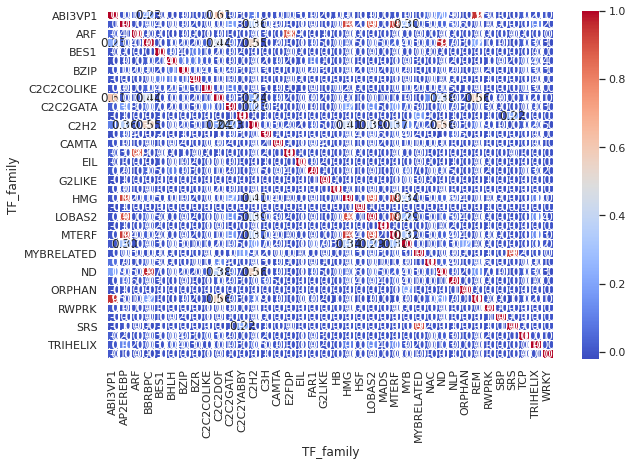

In [38]:
heatmap(mapped_motif_bed)

In [39]:
df

,promoter_AGI,Shannon_diversity_TF,Shannon_diversity_TF_family,unique_TF_count,total_TF_count,TF_family_count,gene,gene_type
0,AT1G01280,2.483127,1.971594,7,29,5,AT1G01280,tissue_specific
1,AT1G01560,2.950212,2.067031,9,14,5,AT1G01560,control
2,AT1G02813,2.251629,1.459148,5,6,3,AT1G02813,tissue_specific
3,AT1G03790,3.001719,2.037210,13,87,7,AT1G03790,tissue_specific
4,AT1G03890,1.219241,1.219241,3,40,3,AT1G03890,tissue_specific
...,...,...,...,...,...,...,...,...
295,AT5G60070,2.447753,1.581754,6,44,4,AT5G60070,tissue_specific
296,AT5G62490,3.438624,2.594801,16,42,8,AT5G62490,tissue_specific
297,AT5G63560,2.730214,2.329882,11,29,7,AT5G63560,tissue_specific
298,AT5G65000,1.737277,1.656251,6,34,5,AT5G65000,control


# run PCA

In [40]:
def run_PCA(mapped_motif_bed):
    """perform a PCA"""
    df = pd.read_table(mapped_motif_bed, sep='\t', header=None)
    cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
    df.columns = cols
    #count no. of TF families binding in each promoter
    groupby_promoter_counts_family = df.groupby('promoter_AGI')['TF_family'].value_counts().unstack(fill_value=0)
    #add gene type column
    groupby_promoter_counts_family = pd.merge(groupby_promoter_counts_family, shannon_Czechowski_gene_categories[['promoter_AGI','gene_type']], on='promoter_AGI')
    
    #standardise the data - have to scale features before applying a PCA. Standardise to mean = 0, variance = 1
    TF_Families = groupby_promoter_counts_family.columns.tolist()
    #remove promoter_AGI and gene_type from column list
    if 'promoter_AGI' in TF_Families: TF_Families.remove('promoter_AGI')
    if 'gene_type' in TF_Families: TF_Families.remove('gene_type')    
    #separate out the families
    x = groupby_promoter_counts_family.loc[:, TF_Families].values
    #separate out the gene_type
    y = groupby_promoter_counts_family.loc[:,['gene_type']].values
    #standardise the families
    x = StandardScaler().fit_transform(x)
    #run PCA, letting the algorithm decide on number of components such that 95% of the variation is maintained
    #make instance of the model
    pca = PCA(.95)
    #fit PCA to the data
    principalComponents = pca.fit_transform(x)
    #make into a dataframe
    principalDf = pd.DataFrame(data= principalComponents)
    #readd AGI and gene_type columns
    finalDF_variable_promoters = pd.concat([principalDf, groupby_promoter_counts_family[['promoter_AGI', 'gene_type']]], axis=1)
    #calculate PCA variance
    pca_variance = pca.explained_variance_ratio_
#     #plot first 2 clusters
#     plot = sns.scatterplot(x=0, y=1, hue='gene_type', data=finalDF_variable_promoters, s=100)
#     plt.xlabel(f'Component 0 {(pca_variance[0]*100).round(1)}% of variance')
#     plt.ylabel(f'Component 1 {(pca_variance[1]*100).round(1)}% of variance');
    
    return finalDF_variable_promoters,pca_variance

In [41]:
def hierarchical_clustering(PCA_df):
    """Run hierarchical clustering"""
    ### hierarchical clustering of PCA including 100 random genes
    
    #separate out the families
    x = PCA_df.drop(['gene_type'],axis=1)
    x = x.set_index('promoter_AGI')
    #separate out the gene_type
    y = PCA_df.loc[:,['gene_type']].values
    
    #plot dendrograms to work out how many clusters to use
    plt.figure(figsize=(10, 7))
    dend = shc.dendrogram(shc.linkage(x, method='ward'), leaf_rotation=45)
    ax = plt.gca()
    x_labels = ax.get_xmajorticklabels()
    plt.savefig(f"../../data/output/{file_names}/TF_diversity/{output_folder_name}plots/hierarchical_clustering_TF_family_counts.pdf")
    #linkage matrix
    z = shc.linkage(x, method='ward')

    return x,z

In [42]:
def elbow_method(z):
    """run elbow method on hierachical clusters to decide how many clusters there are"""
    #decide how many clusters there are
    #try elbow method
    last = z[-10:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    plt.plot(idxs, last_rev)

    acceleration = np.diff(last, 2)  # 2nd derivative of the distances
    acceleration_rev = acceleration[::-1]
    plt.plot(idxs[:-2] + 1, acceleration_rev)
    plt.show()
    k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
    print("clusters:", k)
    return k

In [43]:
def kmeans_clustering(k, PCA_df, x_from_hierarchical_clustering):
    """run kmeans clustering"""
    PCA_kmeans = KMeans(n_clusters=k, random_state=0)
    y_PCA_kmeans = PCA_kmeans.fit_predict(x_from_hierarchical_clustering)
    PCA_df['Kmeans_PCA_cluster']= y_PCA_kmeans
     
    return PCA_df

In [44]:
def plot_kmeans_clusters(k,PCA_df, pca_variance):
    """make two subplots of the first 2 PCA components, the top subplot coloured by KMeans cluster, the bottom coloured by gene_type"""
    #set seaborn graph background
    sns.set(color_codes=True, font_scale=1)
    sns.set_style("white")
    # Create a figure instance, and the two subplots
    fig = plt.figure(figsize=(6,7))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    #add custom palette size as sns doesnt like having numeric values for hue palette=sns.color_palette("Set1", 6)

    plot = sns.scatterplot(x=0, y=1, hue='Kmeans_PCA_cluster', data=PCA_df,s=100, palette=sns.color_palette("Set1", k), ax=ax1)
    plot2 = sns.scatterplot(x=0, y=1, hue='gene_type', data=PCA_df, s=100, ax=ax2, hue_order=["constitutive", variable2_name, "control"]);
    #add graph titles
    ax1.set(ylabel='', title='A')
    ax2.set(xlabel='', ylabel='', title='B')
    fig.tight_layout()

    #Add axes labels
    fig.text(0.5, 0.01, f'PC2 {(pca_variance[1]*100).round(1)}% of variance', ha='center', va='center')
    fig.text(0.0, 0.5, f'PC1 {(pca_variance[0]*100).round(1)}% of variance', ha='center', va='center', rotation='vertical')
   
    fig.savefig(f"../../data/output/{file_names}/TF_diversity/{output_folder_name}plots/PCA_Kmeans_TF_family_counts.pdf")

In [45]:
PCA_df,pca_variance = run_PCA(mapped_motif_bed)

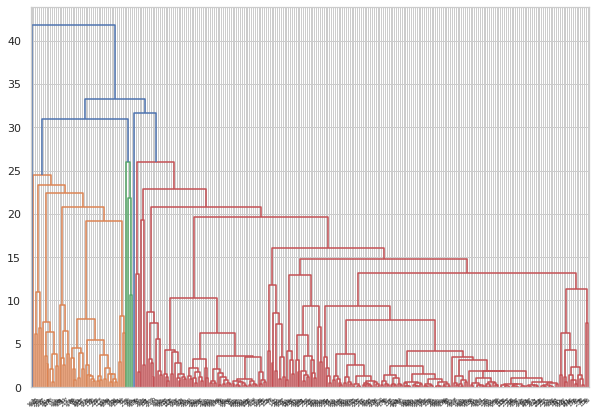

In [46]:
#Run hierarchical clustering
x,z = hierarchical_clustering(PCA_df)

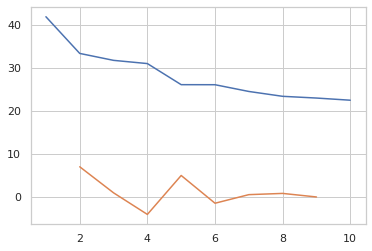

clusters: 2


In [47]:
#decide how many clusters there are
#try elbow method
k = elbow_method(z)

In [51]:
#run kmeans clustering
table = kmeans_clustering(k, PCA_df, x)

In [53]:
table[table.Kmeans_PCA_cluster > 0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,promoter_AGI,gene_type,Kmeans_PCA_cluster
22,12.225600,-0.933630,6.056883,-10.706695,-6.496098,-2.060355,-3.391025,-0.587914,-4.545777,-0.328116,0.748945,-0.113668,0.013164,6.060956,-3.497083,-1.033144,1.580261,AT1G25240,tissue_specific,1
166,9.258119,-0.043342,-0.245289,1.044291,2.319185,-1.111587,-0.362754,-0.822462,0.874018,-0.448005,-1.307966,2.569167,5.920611,0.315364,2.570234,1.652799,1.862479,AT3G42050,constitutive,1
167,26.064462,11.222469,-1.015250,2.444553,1.167389,0.015889,4.812882,1.186250,1.892867,-2.143394,1.765271,-1.822264,-3.509005,-2.508012,0.045549,-0.557855,-0.261507,AT3G42150,constitutive,1
225,10.717749,4.828843,0.732264,-1.462897,0.851814,-0.437487,-2.504634,-2.783630,0.182053,4.145251,-4.887078,2.742008,2.478709,0.935312,-0.258587,-1.311291,-0.578720,AT4G34110,constitutive,1


TypeError: object of type 'int' has no len()

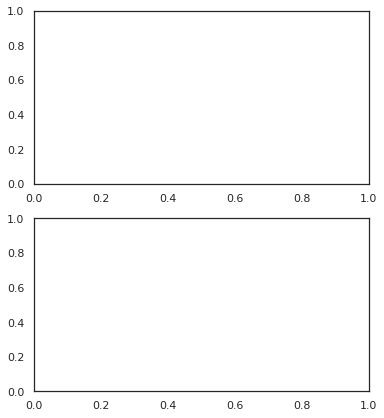

In [49]:
plot_kmeans_clusters(k,PCA_df, pca_variance)